In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scikit_posthocs as sp

%matplotlib inline

# Process diamond output

In [2]:
df = pd.read_csv("../gene_hits.tsv", header=0, index_col=0, sep="\t")

# drop the extra header cols
df = df[df["Query accession"]!="Query accession"]

# Create a sample id and read number columns from query accession 
df["Sample ID"] = df["Query accession"].apply(lambda x: x.split(".")[0])
df["Read number"] = df["Query accession"].apply(lambda x: x.split(".")[1])


## Remove where missing gene names

In [3]:
percent_with_names = sum(df["Gene name"].isna()==False)/df.shape[0]

print(round(percent_with_names*100), "percent of hits matched a gene name on uniprot")

# Only keep where we have a gene name
df = df[df["Gene name"].isna()==False]

42 percent of hits matched a gene name on uniprot


## Get metacyc gene names

In [4]:
pathway_1 = pd.read_csv("../database-building/metacyc-nic-deg-1.txt", 
                        header=1, sep="\t")
pathway_2 = pd.read_csv("../database-building/metacyc-nic-deg-2.txt", 
                        header=1, sep="\t")
pathway_3 = pd.read_csv("../database-building/metacyc-nic-deg-3.txt", 
                        header=1, sep="\t")

metacyc_gene_names = set(pathway_1["Gene name"]) | set(pathway_2["Gene name"]) | set(pathway_3["Gene name"])

## Remove where gene names not in metacyc pathways

In [5]:
df = df[df["Gene name"].apply(lambda x: x in metacyc_gene_names)]

In [6]:
df["E-value"] = df["E-value"].astype(float)

In [7]:
df = df.loc[df.groupby("Read number")["E-value"].idxmin()]

# Metadata

In [8]:
metadata = pd.read_csv("../metadata/metadata.csv")
metadata = metadata.set_index("#SampleID")

In [9]:
SRA1_metadata = pd.read_csv("../metadata/PRJNA508385_SRA_metadata.txt")
SRA2_metadata = pd.read_csv("../metadata/PRJNA548383_SRA_metadata.txt")

# This one was formatted really weirdly... csv in a tsv
SRA3_metadata_weird = pd.read_csv("../metadata/PRJNA544061_SRA_metadata.txt")
SRA3_metadata_data = [str(x) for x in SRA3_metadata_weird.index]
SRA3_metadata = [(x.split(",")[0][2:], x.split(",")[5]) for x in SRA3_metadata_data]
SRA3_metadata = pd.DataFrame(SRA3_metadata, columns=["Run","BioSample"])
SRA3_metadata = pd.concat([SRA3_metadata, SRA3_metadata_weird["Sample Name"].reset_index()],
                          axis=1)

# CHANGE THIS WE NEED SAMPLE NAME NOT BIOSAMPLE

SRA_metadata = pd.concat([SRA1_metadata[["Run","Sample Name"]],
                          SRA2_metadata[["Run","Sample Name"]],
                          SRA3_metadata[["Run","Sample Name"]]],
                        axis=0)
SRA_metadata = SRA_metadata.set_index("Sample Name")

In [10]:
metadata["Run"] = SRA_metadata["Run"]

# Get a count per sample

In [11]:
metadata = metadata.reset_index().set_index("Run")

In [12]:
metadata["Hits"] = df.groupby("Sample ID").count()["Query accession"]

In [13]:
metadata

,#SampleID,GroupName,Description,Age,Gender,Ethnicity,Duration of use,Frequency of use,Type of e-cig device,Nicotine concentration ( per milliliter of e-juice),Hits
Run,,,,,,,,,,,
SRR9641808,HNS126_S6,Never Smoker,HNS126_S6,28,Female,Caucasian,NaN,NaN,NaN,NaN,84.0
SRR9641805,HNS127_S7,Never Smoker,HNS127_S7,29,Male,Caucasian,NaN,NaN,NaN,NaN,22.0
SRR9641806,HNS128_S8,Never Smoker,HNS128_S8,23,Female,Caucasian,NaN,NaN,NaN,NaN,224.0
SRR9641807,HNS129_S9,Never Smoker,HNS129_S9,23,Female,Caucasian,NaN,NaN,NaN,NaN,93.0
SRR9641809,HNS130_S10,Never Smoker,HNS130_S10,25,Female,Caucasian,NaN,NaN,NaN,NaN,113.0
...,...,...,...,...,...,...,...,...,...,...,...
SRR9668722,D355_S41,ENDS Dual Smoker,D355_S41,20,Male,Caucasian,8 months,everyday,e-cig that use cartridges and disposable e-cig...,13 - 16 mg,130.0
SRR9668689,D356_S42,ENDS Dual Smoker,D356_S42,21,Female,Caucasian,3 months,everyday,e-cig that use cartridges,1.5 mg,397.0
SRR9668719,D357_S43,ENDS Dual Smoker,D357_S43,42,Female,Caucasian,1.5 years,everyday,Disposable coils,3 - 6 mg,180.0


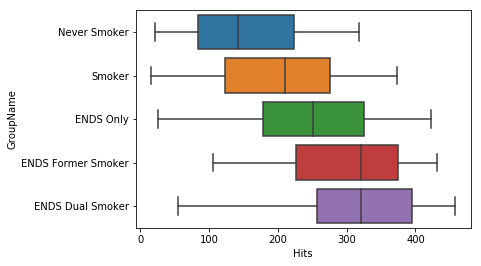

In [14]:
sns.boxplot("Hits",
            "GroupName",
            data=metadata)
plt.show()

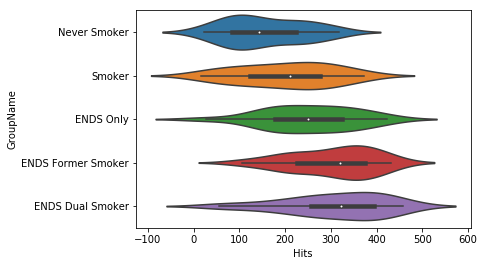

In [15]:
sns.violinplot("Hits",
            "GroupName",
            data=metadata)

In [16]:
never = metadata.loc[metadata["GroupName"]=="Never Smoker", "Hits"]
smoker = metadata.loc[metadata["GroupName"]=="Smoker", "Hits"]
ENDS = metadata.loc[metadata["GroupName"]=="ENDS Only", "Hits"]
ENDS_former = metadata.loc[metadata["GroupName"]=="ENDS Former Smoker", "Hits"]
ENDS_dual = metadata.loc[metadata["GroupName"]=="ENDS Dual Smoker", "Hits"]

In [17]:
stats.kruskal(never, smoker, ENDS, ENDS_former, ENDS_dual,
              nan_policy="omit")

KruskalResult(statistic=33.107090188951595, pvalue=1.1356684186333574e-06)

In [18]:
sp.posthoc_dunn(a=metadata, val_col="Hits", group_col="GroupName", 
                #p_adjust = 'holm'
               )

,ENDS Dual Smoker,ENDS Former Smoker,ENDS Only,Never Smoker,Smoker
ENDS Dual Smoker,1.000000,0.917936,0.105184,0.000002,0.000925
ENDS Former Smoker,0.917936,1.000000,0.137100,0.000007,0.001778
ENDS Only,0.105184,0.137100,1.000000,0.006151,0.139790
Never Smoker,0.000002,0.000007,0.006151,1.000000,0.189651
Smoker,0.000925,0.001778,0.139790,0.189651,1.000000


## Normalize for total reads
Have to do some cleaning bc I formatted poorly - will address later

In [19]:
with open("num_reads.txt") as f:
    contents = f.readlines()
contents = [content.strip().split("\\t") for content in contents]

In [20]:
num_reads_df = pd.DataFrame(contents, columns=["filepath", "num reads"])
num_reads_df = num_reads_df.replace("", np.NaN)
num_reads_df = num_reads_df[num_reads_df["num reads"].isna()==False]

In [21]:
num_reads_df["Sample"] = num_reads_df["filepath"].apply(lambda x: x.split("/")[-1].strip())
num_reads_df = num_reads_df.set_index("Sample")

In [22]:
metadata["Num reads"] = num_reads_df["num reads"].astype(int)

In [23]:
metadata["Hits per read"] = metadata["Hits"]/metadata["Num reads"]

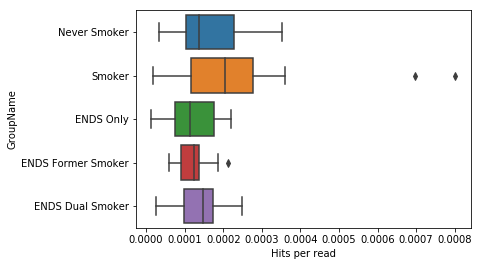

In [24]:
sns.boxplot("Hits per read",
            "GroupName",
            data=metadata)
plt.show()

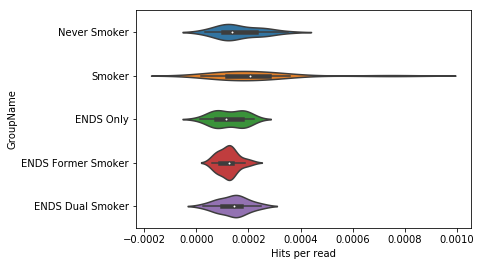

In [25]:
sns.violinplot("Hits per read",
            "GroupName",
            data=metadata)
plt.show()

In [26]:
never = metadata.loc[metadata["GroupName"]=="Never Smoker", "Hits per read"]
smoker = metadata.loc[metadata["GroupName"]=="Smoker", "Hits per read"]
ENDS = metadata.loc[metadata["GroupName"]=="ENDS Only", "Hits per read"]
ENDS_former = metadata.loc[metadata["GroupName"]=="ENDS Former Smoker", "Hits per read"]
ENDS_dual = metadata.loc[metadata["GroupName"]=="ENDS Dual Smoker", "Hits per read"]

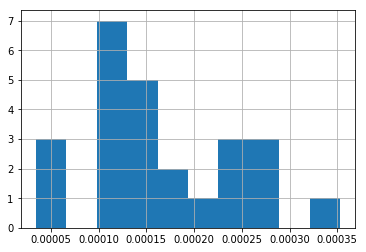

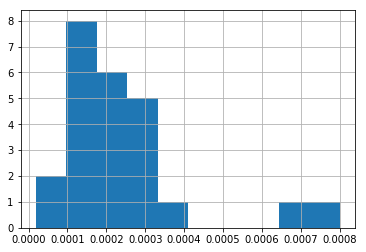

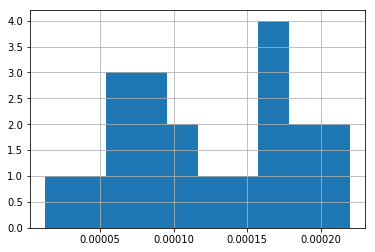

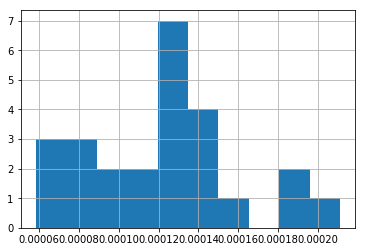

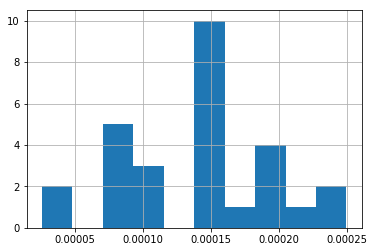

In [27]:
groups = [never, smoker, ENDS, ENDS_former, ENDS_dual]

for group in groups:
    group.hist()
    plt.show()

In [28]:
stats.kruskal(never, smoker, ENDS, ENDS_former, ENDS_dual,
              nan_policy="omit")

KruskalResult(statistic=11.685252375240395, pvalue=0.01985191934429646)

In [29]:
names = metadata["GroupName"].unique()

pairwise_results_p = np.zeros(shape=(len(groups), len(groups)), )
pairwise_results_stat = np.zeros(shape=(len(groups), len(groups)))
for i, first_group in enumerate(groups):
    for j in range(i+1, len(groups)):
        second_group = groups[j]
        stat, p = stats.mannwhitneyu(first_group, second_group)
        pairwise_results_p[i,j] = p
        pairwise_results_stat[i,j] = stat

In [30]:
print("pvals")
pd.DataFrame(pairwise_results_p, index=names, columns=names)

pvals


,Never Smoker,Smoker,ENDS Only,ENDS Former Smoker,ENDS Dual Smoker
Never Smoker,0.0,0.060304,0.083499,0.043869,0.275293
Smoker,0.0,0.000000,0.002758,0.001805,0.010518
ENDS Only,0.0,0.000000,0.000000,0.495444,0.255034
ENDS Former Smoker,0.0,0.000000,0.000000,0.000000,0.047864
ENDS Dual Smoker,0.0,0.000000,0.000000,0.000000,0.000000


In [31]:
print("test statistic")
pd.DataFrame(pairwise_results_stat, index=names, columns=names)

test statistic


,Never Smoker,Smoker,ENDS Only,ENDS Former Smoker,ENDS Dual Smoker
Never Smoker,0.0,232.0,189.0,224.0,316.0
Smoker,0.0,0.0,128.0,162.0,220.0
ENDS Only,0.0,0.0,0.0,250.0,248.0
ENDS Former Smoker,0.0,0.0,0.0,0.0,256.0
ENDS Dual Smoker,0.0,0.0,0.0,0.0,0.0


In [32]:
sp.posthoc_dunn(a=metadata, val_col="Hits per read", group_col="GroupName", 
                #p_adjust = 'holm'
               )

,ENDS Dual Smoker,ENDS Former Smoker,ENDS Only,Never Smoker,Smoker
ENDS Dual Smoker,1.000000,0.222664,0.368169,0.576618,0.056151
ENDS Former Smoker,0.222664,1.000000,0.810104,0.083714,0.002419
ENDS Only,0.368169,0.810104,1.000000,0.164430,0.008666
Never Smoker,0.576618,0.083714,0.164430,1.000000,0.186345
Smoker,0.056151,0.002419,0.008666,0.186345,1.000000
